# Configuraciones iniciales (Grafica y Equipo)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# lA ID de la GPU a usar, puede ser desde 0 hasta las N GPU's. Si es -1 significa que es en la CPU
os.environ["CUDA_VISIBLE_DEVICES"]="1";

#Si se esta trabajando en colab la variable debe quedar en falso
SERVER = True

# Importaciones

## Librerias

### Instaladas python

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import display, clear_output
from ipywidgets import interact, IntSlider
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
from collections import namedtuple
if not SERVER:
    !pip -q install -U nltk==3.4.5
    %tensorflow_version 2.x
import tensorflow as tf
import nltk

In [3]:
# Establezco el crecimiento de la grafica a medida que necesite memoria
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.debugging.set_log_device_placement(False)

### Propias y externas

In [4]:
if SERVER:
    !git pull
else:
    #Archivos py
    !git clone https://github.com/JefeLitman/SignLanguageTranslation_SLT.git
    #Organizacion archivos
    !mv /content/SignLanguageTranslation_SLT/utils /content/
    !mv /content/SignLanguageTranslation_SLT/models /content/
    !mv /content/SignLanguageTranslation_SLT/metrics /content/
    #Elimino la carpeta sobrante
    !rm -rf /content/SignLanguageTranslation_SLT
#DatasetsLoaderUtils
!wget -q https://raw.githubusercontent.com/JefeLitman/VideoDataGenerator/master/DatasetsLoaderUtils.py -O DatasetsLoaderUtils.py
!mv DatasetsLoaderUtils.py utils/DatasetsLoaderUtils.py

Already up to date.


In [5]:
from utils.preprocess_data import preprocessing_paths, preprocessing_sentences, table_paths_dataset
from utils.build_tf_data import build_datasets
from metrics.losses import SparseCategoricalCrossentropy_mask
from models import compute_features, encoder, decoder, reduce_features, self_attentions, st_attentions, output

## Datos

In [6]:
if not SERVER:
    !rm -rf /content/sample_data
    # Se esta descargando la data de Boston201
    !wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Ph_Ys3O_vI93WeTkDqr5h6kTJm0CZ0Ub' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Ph_Ys3O_vI93WeTkDqr5h6kTJm0CZ0Ub" -O boston201.zip && rm -rf /tmp/cookies.txt
    !unzip -q boston201.zip
    !rm boston201.zip
    !wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip -O word_vectors.zip
    !unzip -q word_vectors.zip
    !rm word_vectors.zip
    # Monto el drive para poder tener donde guardar los datos
    from google.colab import drive
    drive.mount('/content/drive')

# Modelo SLT

## Parametros de la red

In [7]:
Args = namedtuple('Args', 'max_len_sentence data pretrained prefetch_batch_buffer unitsEmbedding vocab_size nIters videos_path rnnUnits dropout recurrent_dropout inputShape optimizer type_frames batchSize epochs lr momentum decay wDecay path2save name')

args = Args(max_len_sentence=15,
            videos_path='../DataSets/boston201',#'/content/boston201',
            rnnUnits=256,
            unitsEmbedding=300,
            vocab_size=150,
            dropout=0.2,
            recurrent_dropout=0.2,
            inputShape=(32, 112, 112, 3),
            pretrained=None,#'vgg16',
            optimizer='adam',
            type_frames='jpg/',
            batchSize=1,
            epochs=20,
            nIters=10.0,
            lr=0.001,
            momentum=0.99,
            decay=0.1,
            wDecay=0.0005,
            path2save='path_to_save_model_results',
            name='SLT_Model',
            data= '../DataSets/boston201/data/', #'/content/boston201/data/',
            prefetch_batch_buffer = 5
           )

## Preparacion datos

In [8]:
paths_translation = [args.data+'translations.train',  
                         args.data+'translations.test']
paths_videos = [args.data+'pathsigns.train', 
                    args.data+'pathsigns.test']

# Processing sentences and paths
preprocessed_sentences, vocab = preprocessing_sentences(paths_translation, max_len=args.max_len_sentence)
preprocessed_paths = preprocessing_paths(paths_videos, path2videos=args.videos_path, type_=args.type_frames)

#Creating table paths
table_paths=table_paths_dataset(preprocessed_paths, preprocessed_sentences)

#Get the train, test and dev data
train_data, test_data, dev_data = build_datasets(table_paths, args)

Reading training file ...
training on train sentences to make the vocab ...
training text to index sequences ..
training index sequences to padded sequences ..
Computing same steps over dev and test sequences
Completed
Completed
Creating the table paths for flow_from_tablePaths ..


## Creacion y estructuracion

In [8]:
# Entradas de la red
input_video = tf.keras.Input(shape=args.inputShape, batch_size=args.batchSize, name="input_video")
input_words = tf.keras.Input(shape=[args.max_len_sentence], batch_size=args.batchSize, name="input_words")

# Compute features and reduce features
x = compute_features.compute_features_v1_0(input_video, weight_decay=tf.keras.regularizers.l2(args.wDecay))
x = reduce_features.reduce_features_v1_2(x)

#Encoder module and self attention
x1, rnn1_states, rnn2_states = encoder.encoder_v1_1(x, args.rnnUnits, args.unitsEmbedding, 
    args.dropout, args.recurrent_dropout)
x1 = self_attentions.self_attention_v1_0(x1)

#Decoder module
x2 = decoder.decoder_v1_0(input_words, rnn1_states, rnn2_states, args.rnnUnits, args.unitsEmbedding, 
    args.vocab_size, args.dropout, args.recurrent_dropout)

# Spatio Temporal attention
x3 = st_attentions.st_attention_v1_4_1(x2, x1, x)

# Output of the network
x = output.output_v1_0(x2, x3, args.vocab_size)

model = tf.keras.Model(inputs=[input_video, input_words], outputs=x, name=args.name)

In [ ]:
model.summary()

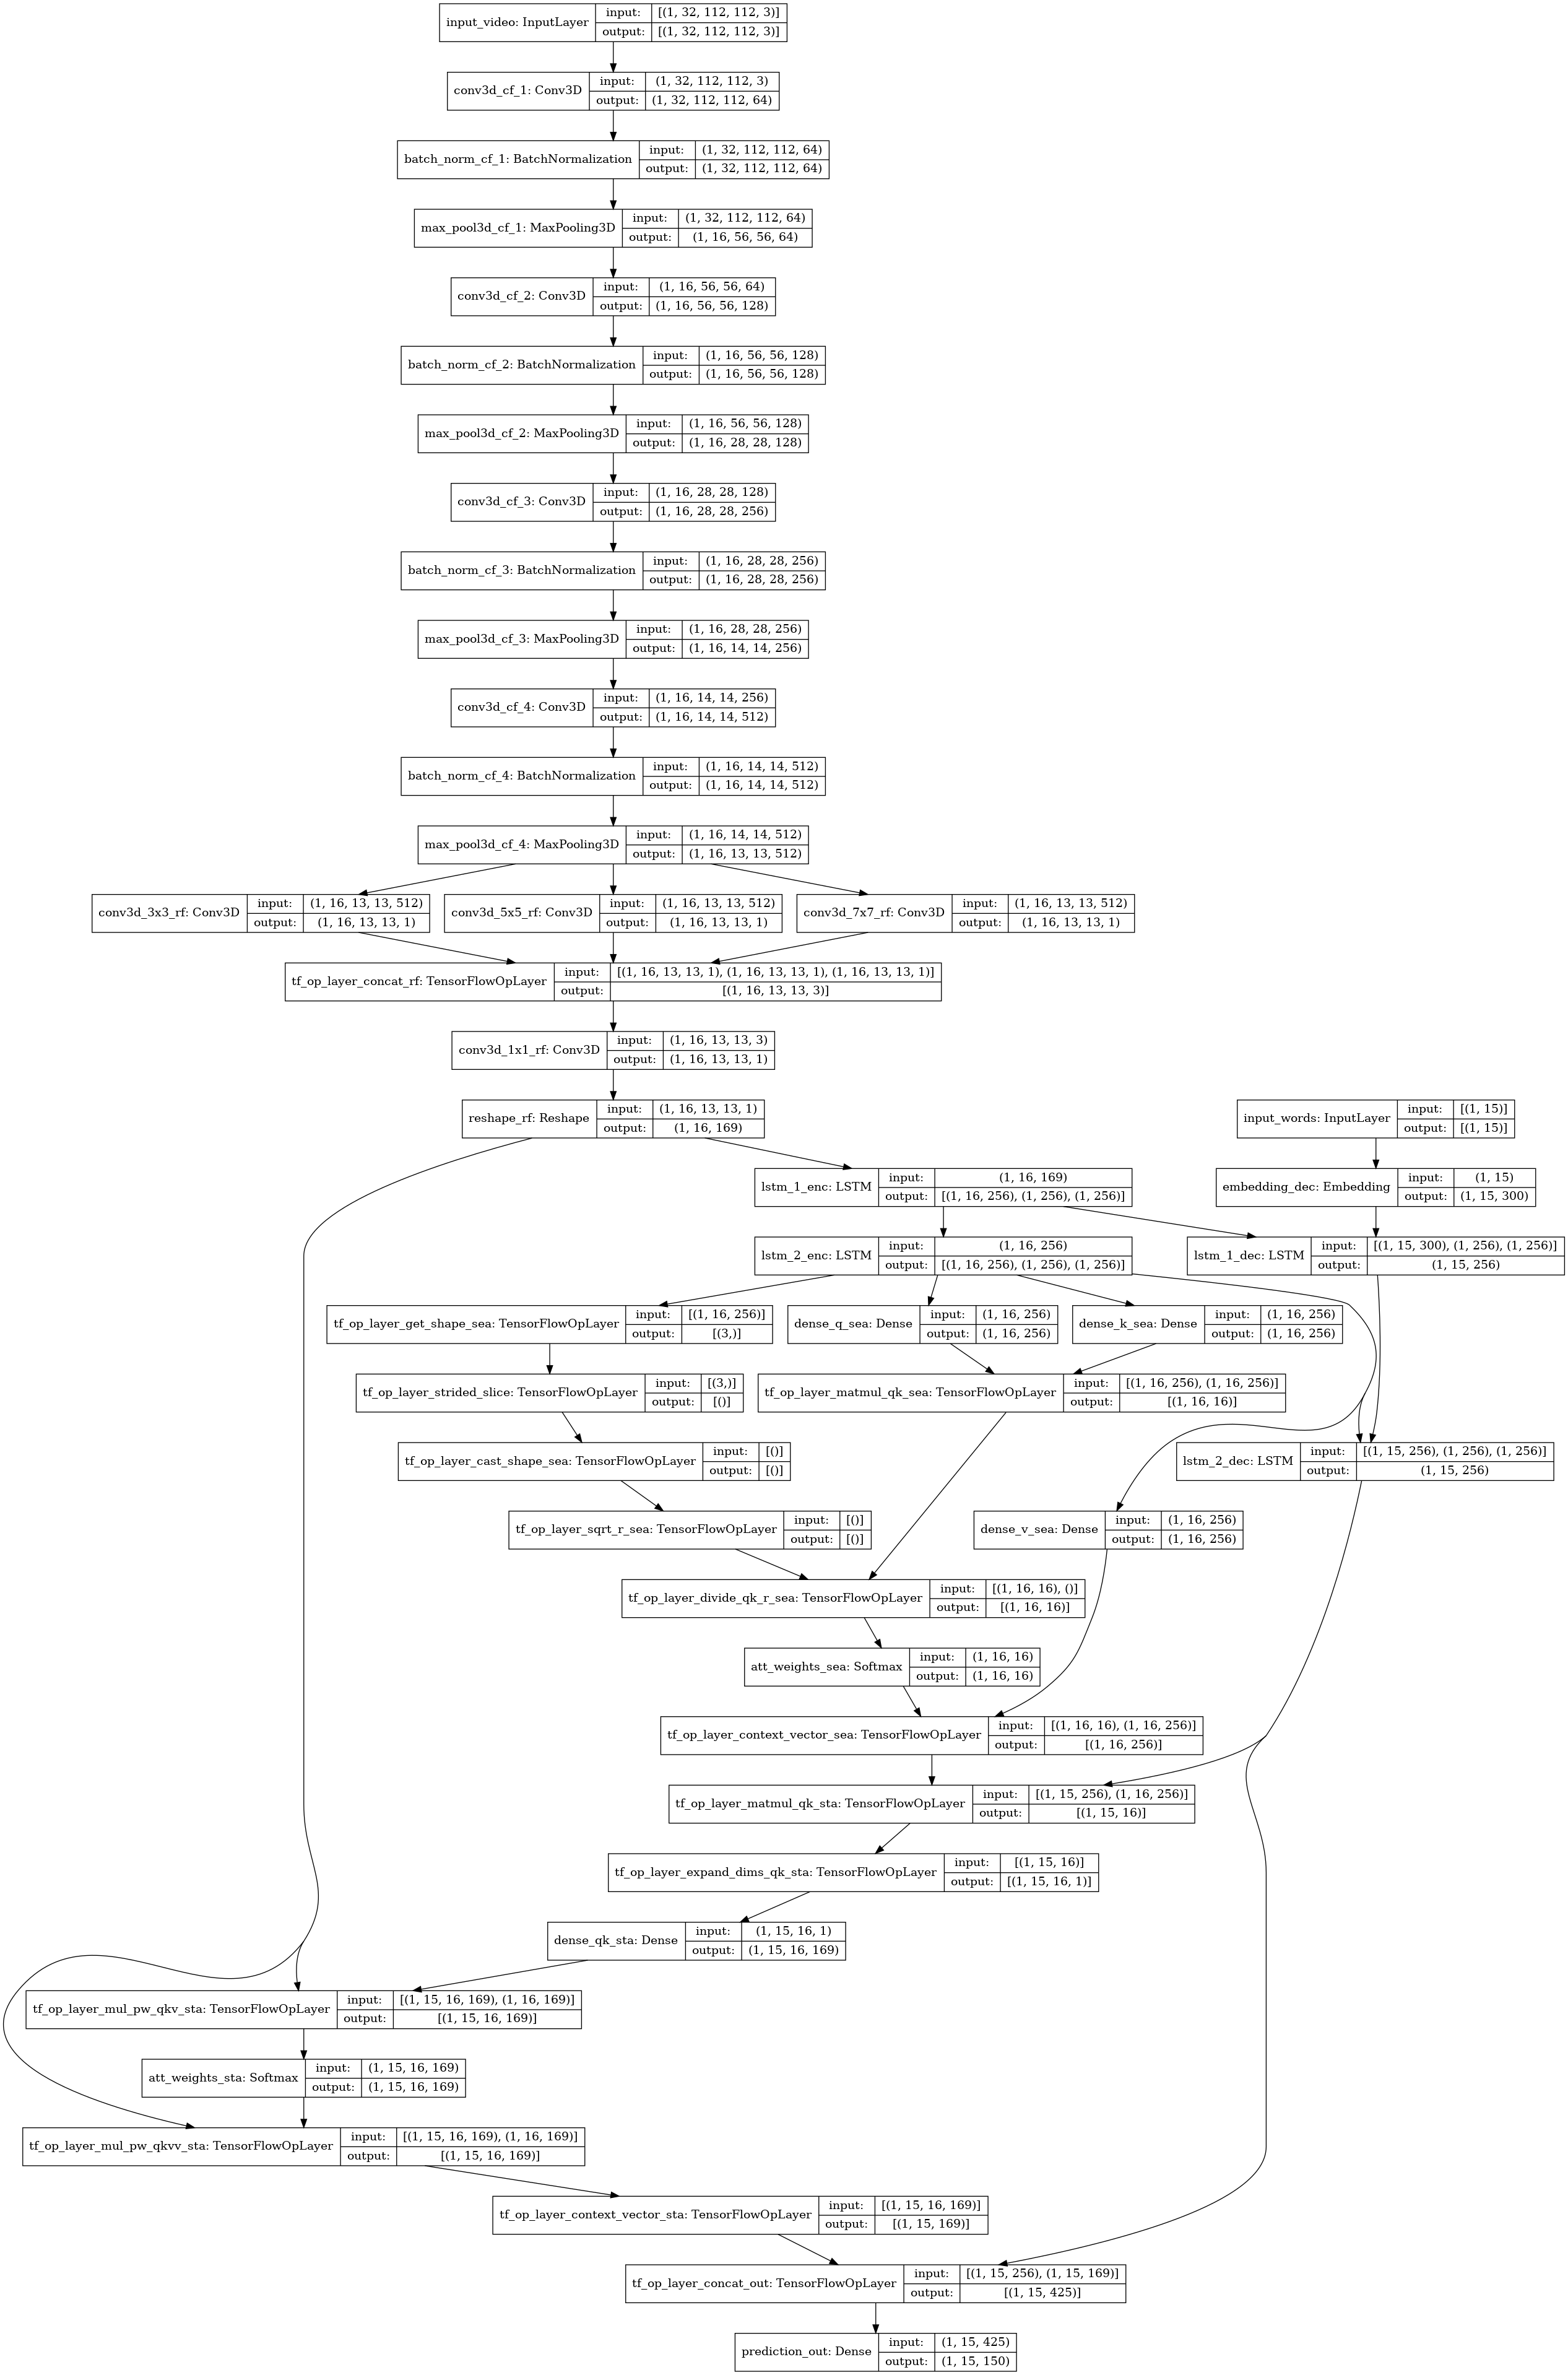

In [9]:
tf.keras.utils.plot_model(model, to_file=args.name+'.png', show_shapes=True)

## Entrenamiento

In [9]:
def step_decay(epoch):
    initial_lrate = args.lr
    drop = args.decay
    epochs_drop = args.nIters
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate
lrate_sheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [ ]:
if args.optimizer == 'adam':
    opt = tf.keras.optimizers.Adam(
        lr=args.lr, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=1e-08, 
        decay=0.0, 
        clipnorm=1., 
        clipvalue=5)

elif args.optimizer == 'sgd':
    opt = tf.keras.optimizers.SGD(
        lr=args.lr, 
        decay=0, 
        momentum=args.momentum, 
        nesterov=True, 
        clipnorm=1., 
        clipvalue=0.5)

elif args.optimizer == 'rsmprop':
    opt = tf.keras.optimizers.RMSprop(lr=args.lr) 
                         #clipnorm=1., 
                         #clipvalue=0.5)      
else:
    raise ValueError('You must specify a valid optimizer for model. The only optmizers available are: '
                    '"adam", "sgd" or "rmsprop". The optmizer given was: '+str(args.optimizer))
acc = tf.keras.metrics.SparseCategoricalAccuracy(name="acc")

In [ ]:
for v,l in train_data.take(1):
    

In [ ]:
model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy_mask, metrics=[acc])
model.fit_generator(generator=training_generator,
                              use_multiprocessing=True,
                              workers=4,
                              epochs=args.epochs,
                              callbacks=callbacks_list)#validation_data=validation_generator,